Intro
-----
This notebook is my end-to-end CBIS-DDSM preprocessing and quality-assurance pipeline that prepares the dataset for downstream deep learning. My goal is to turn the raw CSV metadata and JPEG assets into clean, verifiable, and ML-ready tables that I can feed directly into training and evaluation without ad-hoc fixes later.

What I am optimizing for
- correctness: images, masks, and cropped ROIs are consistently resolved and aligned
- reproducibility: the same inputs produce the same outputs across runs and machines
- auditability: every transformation is explicit and traceable from raw to model-ready
- readiness: exported tables have the exact columns my data loaders expect

Scope and assumptions
- source: the official CBIS-DDSM splits (calcification and mass; train and test), plus dicom_info and meta CSVs
- file layout: I assume a dataset root (BASE_DIR) with jpeg subfolders that mirror the CSV “image file path” structure
- mask identification: masks are JPEGs with low gray-level diversity; I use a simple unique-values heuristic unless filenames provide stronger cues
- metadata completeness: laterality and view may be missing; I create placeholders to preserve schema

Research questions I want the data to answer
1) after normalization, what is the effective label distribution (malignant, benign, benign_without_callback) and how does it translate to binary vs three-class training objectives
2) are laterality (LEFT/RIGHT) and view (CC/MLO) balanced enough to avoid hidden bias, and how should I stratify my splits
3) do image, mask, and cropped ROI paths resolve deterministically, and are there systematic failure modes I need to mitigate

Deep learning workflow I follow
1) data access and environment setup
2) metadata ingestion and schema checks
3) deterministic path resolution for images, masks, and cropped ROIs
4) label normalization and hard filtering of unusable rows
5) exploratory diagnostics and visual sanity checks to catch mapping errors early
6) consolidated exports for training and evaluation
7) construction of ML-ready tables with numeric targets and one-hot metadata
8) final exports per abnormality type to support task-specific training

Reproducibility plan
- I pin key library versions in the environment
- I use fixed random seeds for sampling and previews
- I normalize column names and enforce a fixed output schema
- I keep all export paths explicit and write once per run to avoid accidental drift

Outputs I produce
- a consolidated all-splits CSV with resolved paths, normalized labels, laterality, view, and split tags
- a train-only CSV for quick visual checks
- per-abnormality CSVs (calcification and mass) with labels mapped to integers and one-hot metadata encoded as compact types

Out of scope for this notebook
- model architecture definition, training loops, and hyperparameter search
- clinical evaluation or claims; this is dataset curation and QA only

I keep the implementation lightweight so I can iterate quickly on experiments, while keeping enough instrumentation to detect leakage, skew, or broken assets before training begins.


In [1]:
# === Standard Libraries ===
import os
import numpy as np
import pandas as pd

# === Image Processing ===
from PIL import Image

# === Data Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning / Metrics ===
import sklearn  # imported for completeness in my DL workflow (metrics/modeling in future steps)

# === Jupyter Notebook Utilities ===
from IPython.display import display


Load raw metadata
-----------------
In this step I ingest the official CBIS-DDSM CSVs that define the dataset split and link out to the JPEG assets on disk. I intentionally load each source as a separate table to preserve the original semantics and to avoid accidental mixing of train and test or mass and calcification records.

What I load and why I keep them separate
- calc_case_description_train_set.csv and calc_case_description_test_set.csv
  these describe calcification studies and already encode the intended split. keeping them separate prevents leakage when I build patient-level splits later.
- mass_case_description_train_set.csv and mass_case_description_test_set.csv
  these describe mass studies. again, I keep train and test separate to respect the official partitioning.
- dicom_info.csv
  image-level metadata that can be useful for auditing image provenance or cross-checking study structure. I do not rely on it for core path resolution, but I keep it available for diagnostics.
- meta.csv
  study or patient level details that help with patient-level split validation and subgroup analyses.

Schema expectations I rely on downstream
- image file path: relative path that I use to derive the JPEG folder name
- ROI mask file path: relative path that I use to locate candidate mask JPEGs
- cropped image file path: relative path used to locate candidate cropped ROI JPEGs
- pathology: raw label that I normalize into malignant, benign, or benign_without_callback
- abnormality type: mass or calcification, used for per-task exports
- left or right breast and image view: metadata I carry through and later one-hot encode

Robust loading decisions
- I read CSVs without attempting to coerce types for identifiers or paths. ids and paths are treated as strings to avoid unwanted numeric conversion and to preserve leading zeros.
- I let pandas infer missing values but I do not drop any rows at this stage. filtering happens in a later cell after I have deterministic path resolution and label normalization in place.
- I log shapes and column names immediately after loading. this gives me a reproducible snapshot of what the raw files contained at the time of processing.

Immediate sanity checks after load
- verify that left or right breast and image view exist; if missing in a file, I add placeholder columns later to keep the downstream schema consistent
- confirm that pathology and abnormality type are present since they are required for label normalization and per-task exports
- check for obviously broken files such as empty tables or unexpected column name drift

Assumptions and caveats
- I assume the jpeg folder structure under BASE_DIR mirrors the final folder component implied by the CSV paths. if that assumption changes, I will amend the path resolution logic but keep the loading stage unchanged.
- I assume that dicom_info.csv and meta.csv may contain extra fields not strictly needed for training; I keep them for auditability and optional cross-checks, but the core pipeline does not depend on them.
- I do not merge tables in this cell. all joins or concatenations happen explicitly later so that I can reason about split integrity and failure modes in isolation.

Outcome of this cell
- six dataframes in memory that exactly reflect the raw inputs, with no filtering applied yet
- printed shapes and column inventories that serve as a lightweight data contract for the rest of the notebook


In [2]:
# Load case description files for calcification and mass abnormalities
calc_test_df = pd.read_csv('csv/calc_case_description_test_set.csv')   # Calcification test set metadata
calc_train_df = pd.read_csv('csv/calc_case_description_train_set.csv') # Calcification training set metadata
mass_train_df = pd.read_csv('csv/mass_case_description_train_set.csv') # Mass training set metadata
mass_test_df = pd.read_csv('csv/mass_case_description_test_set.csv')   # Mass test set metadata

# Load DICOM image metadata and general study-level metadata
dicom_info_df = pd.read_csv('csv/dicom_info.csv')                      # Image-level DICOM information
meta_df = pd.read_csv('csv/meta.csv')                                  # General study/patient metadata

Configuration and quick schema checks
-------------------------------------
In this step I declare the dataset root (BASE_DIR) and the two metadata fields I want to carry through the pipeline: laterality and view. I then run lightweight integrity checks that give me a fast signal on whether the raw CSVs look as expected before I do any expensive processing.

What I configure
- BASE_DIR points to the CBIS-DDSM root on disk where jpeg subfolders reside
- LATERALITY_COL and VIEW_COL are the canonical column names I expect to find and preserve downstream

What I check immediately and why
- I print the shape of each loaded table (rows, columns) to spot empty files or obvious truncation
- I list the column names so I can detect schema drift early (renames, extra/missing fields)
- I warn if the required metadata columns are absent; if they are missing, I will create placeholders later so that the downstream schema remains stable

Design intent
- fail fast on structural issues without mutating data in place at this stage
- establish a simple, reproducible contract for the rest of the notebook: if shapes and columns look right here, later cells can assume a consistent schema
- keep the checks cheap enough to run on every iteration so I notice regressions the moment they appear

Assumptions
- the CSVs may include additional columns that I do not use; I leave them untouched
- laterality and view may be missing in some splits; I prefer to add NA placeholders later rather than silently dropping rows at this point

Outcome of this cell
- a validated understanding of file dimensions and available fields
- early warnings for missing laterality/view that I will handle explicitly in the preprocessing stage


In [12]:
# === CONFIG / CONSTANTS ===
BASE_DIR = r'C:\Users\PC\Desktop\final project\CBIS-DDSM'
data_dir = os.path.join(BASE_DIR, 'data')

LATERALITY_COL = "left or right breast"
VIEW_COL       = "image view"
REQUIRED_META  = [LATERALITY_COL, VIEW_COL]

# --- Shapes ---
print(f"Calc train set: {calc_train_df.shape}")
print(f"Calc test set: {calc_test_df.shape}")
print(f"Mass train set: {mass_train_df.shape}")
print(f"Mass test set: {mass_test_df.shape}")
print(f"DICOM info: {dicom_info_df.shape}")
print(f"Meta data: {meta_df.shape}")

# --- Columns overview ---
print("\nColumns in calc_train_df:", calc_train_df.columns.tolist())
print("\nColumns in mass_train_df:", mass_train_df.columns.tolist())
print("\nColumns in calc_test_df:",  calc_test_df.columns.tolist())
print("\nColumns in mass_test_df:",  mass_test_df.columns.tolist())

# Quick sanity: make sure laterality & view exist in the source CSVs
for name, d in {
    "calc_train_df": calc_train_df,
    "calc_test_df":  calc_test_df,
    "mass_train_df": mass_train_df,
    "mass_test_df":  mass_test_df,
}.items():
    missing = [c for c in REQUIRED_META if c not in d.columns]
    if missing:
        print(f"[WARN] {name} is missing columns: {missing}")


Calc train set: (1546, 14)
Calc test set: (326, 14)
Mass train set: (1318, 14)
Mass test set: (378, 14)
DICOM info: (10237, 38)
Meta data: (6775, 9)

Columns in calc_train_df: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

Columns in mass_train_df: ['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

Columns in calc_test_df: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

Columns in mass_test_df:

Helper functions for paths and labels
-------------------------------------
This section is where I make the dataset operational: I turn the abstract CSV references into concrete file paths and normalize labels into a stable target space. My goals here are determinism, debuggability, and minimal hidden magic.

What I resolve and why it matters
- image_path
  derived from the CSV’s `image file path`. I map the last folder component onto my `BASE_DIR/jpeg/...` layout and select a JPEG deterministically. This gives me a stable pointer to the source mammogram for every row.
- mask_path
  derived from `ROI mask file path`. I scan the corresponding folder and choose the file that looks like a mask based on a simple gray-level heuristic. This enables rapid visual QA and later supervised localization checks.
- cropped_image_path
  derived from `cropped image file path`. I pick a non-mask JPEG from the same folder as a pragmatic cropped ROI. This supports quick model prototyping when I want to bypass detection and study classification directly on ROIs.
- label
  I normalize raw `pathology` strings into a compact label set: `malignant`, `benign`, `benign_without_callback`. Keeping the ontology small and explicit reduces ambiguity during training targets construction.

Deterministic selection strategy
- folder mapping
  I do not trust absolute paths inside the CSVs. Instead, I extract the final directory key from the provided CSV path and re-root it under `BASE_DIR/jpeg/<key>`. This isolates me from machine-specific absolute paths and keeps the pipeline portable.
- file picking policy
  multiple JPEGs can exist in a folder. I sort filenames and select the first one. This is intentionally simple and reproducible. If filenames encode roles (for example “mask” or “crop” substrings), I can override the policy with explicit pattern filters later.
- mask heuristic
  I treat an image as a mask if the number of unique grayscale values is small (default ≤ 20). Real photographs tend to have thousands of unique levels, whereas binary or quantized masks are sparse in the value space. This gives me a high-precision filter in practice without adding brittle filename dependencies.

Failure modes I account for
- missing folders or empty directories
  I log a clear message and return `None`. Downstream I drop rows that cannot resolve both a usable image and mask. This prevents late failures during training.
- ambiguous folders with multiple candidates
  the sort-first policy makes the choice reproducible. If I later discover consistent mis-selections in a subset, I can harden the rules with filename patterns or additional heuristics while keeping the default behavior intact.
- unexpected labels
  unknown or NaN `pathology` values are mapped to `None` and filtered early. It is better to lose a few rows deterministically than to silently mislabel examples.

Why I prefer a gray-level heuristic for masks at this stage
- it is data-driven and decoupled from file naming conventions
- it is fast to compute and works well with JPEG artifacts
- it avoids premature dependencies on DICOM headers or external tooling
If I later need higher precision, I can layer complementary checks (entropy thresholds, Otsu binarization score, connected-component sparsity) or leverage filename patterns when consistently present.

Reproducibility and portability considerations
- I never mutate the raw columns; all derived paths live in new columns
- I rely on relative folder keys rather than absolute on-disk strings
- all selection rules are deterministic (sorting, fixed thresholds)
- logging is explicit so I can audit discarded rows and trace issues back to the source folders

Possible extensions if the project demands them
- filename pattern rules
  prefer files matching regexes like `.*mask.*` or `.*cropped.*` when present, with a safe fallback to the current heuristic
- weak alignment checks
  compute a quick overlap proxy by resizing the mask to the image and verifying that foreground occupies a plausible fraction of the field of view
- path caching
  memoize directory listings for large-scale passes to reduce I/O overhead
- cross-check with DICOM
  when available, validate that derived JPEGs correspond to the intended series or instance via a lightweight manifest matched on identifiers

Outcome of this cell
- for each row, I either have a consistent triple `(image_path, mask_path, cropped_image_path)` and a normalized `label`, or I have a logged reason why the row will be filtered out
- the rest of the pipeline can assume that path columns point to real files on disk, which simplifies both visualization and downstream data loading


In [4]:
# === Helpers ===
def normalize_pathology(label):
    """Normalize raw pathology strings to a small fixed set I use downstream."""
    if pd.isna(label):
        print("Warning: pathology label is NaN")
        return None
    label = str(label).upper()
    if label == 'MALIGNANT':
        return 'malignant'
    elif label == 'BENIGN_WITHOUT_CALLBACK':
        return 'benign_without_callback'
    elif label == 'BENIGN':
        return 'benign'
    else:
        print(f"Unknown pathology label: {label}")
        return None

def get_jpeg_image_path(row):
    """
    Resolve the primary image JPEG path from the row's 'image file path'.
    I map from the CSV path to my BASE_DIR/jpeg/<folder_name> and pick the first JPEG.
    """
    try:
        parts = row['image file path'].split('/')
        folder_name = parts[-2]
        folder_path = os.path.join(BASE_DIR, 'jpeg', folder_name)
        if not os.path.exists(folder_path):
            print(f"Image folder does not exist: {folder_path}")
            return None
        jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        if len(jpg_files) == 0:
            print(f"No JPEG files found in image folder: {folder_path}")
            return None
        return os.path.join(folder_path, sorted(jpg_files)[0])
    except Exception as e:
        print(f"Error in get_jpeg_image_path: {e}")
        return None

def is_mask_image(img_path, threshold_unique_values=20):
    """
    Heuristic to decide if a JPEG is actually a mask:
    low unique gray levels typically indicate masks.
    """
    try:
        img = Image.open(img_path).convert('L')
        arr = np.array(img)
        unique_vals = np.unique(arr)
        return len(unique_vals) <= threshold_unique_values
    except Exception as e:
        print(f"Error in is_mask_image: {e}")
        return False

def get_jpeg_mask_path(row):
    """
    Resolve a mask JPEG from 'ROI mask file path' by scanning the target folder
    and picking the first file that looks like a mask (fallback: first JPEG).
    """
    try:
        parts = row['ROI mask file path'].split('/')
        folder_name = parts[-2]
        folder_path = os.path.join(BASE_DIR, 'jpeg', folder_name)
        if not os.path.exists(folder_path):
            print(f"Mask folder does not exist: {folder_path}")
            return None
        jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        for jpg_file in sorted(jpg_files):
            full_path = os.path.join(folder_path, jpg_file)
            if is_mask_image(full_path):
                return full_path
        return os.path.join(folder_path, sorted(jpg_files)[0]) if jpg_files else None
    except Exception as e:
        print(f"Error in get_jpeg_mask_path: {e}")
        return None

def get_jpeg_cropped_image_path(row):
    """
    Resolve a cropped ROI JPEG by scanning the target folder and picking the first
    non-mask JPEG (fallback: first JPEG).
    """
    try:
        parts = row['cropped image file path'].split('/')
        folder_name = parts[-2]
        folder_path = os.path.join(BASE_DIR, 'jpeg', folder_name)
        if not os.path.exists(folder_path):
            print(f"Cropped image folder does not exist: {folder_path}")
            return None
        jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        for jpg_file in sorted(jpg_files):
            full_path = os.path.join(folder_path, jpg_file)
            if not is_mask_image(full_path):
                return full_path
        return os.path.join(folder_path, sorted(jpg_files)[0]) if jpg_files else None
    except Exception as e:
        print(f"Error in get_jpeg_cropped_image_path: {e}")
        return None

Row preprocessing
-----------------
This is where I turn raw tables into a curated, analysis-ready frame with stable paths and normalized targets. The function operates on a single dataframe and returns a copy that passes a set of invariants I rely on later (training, visualization, and exports).

Objectives
- enforce a consistent schema across splits and sources (laterality, view, label, and resolved paths always present)
- guarantee that every retained row points to files that actually exist on disk
- normalize the label space to a compact, unambiguous set
- keep the transformation deterministic and auditable

What I do, in order
1) defensive copy  
   I work on a copy to keep the original dataframe unchanged for debugging and for cross-checks.
2) schema repair  
   if laterality or view are missing in the source CSV, I create those columns filled with NA so downstream code can assume a fixed schema.
3) label normalization  
   I convert the raw `pathology` field into one of `malignant`, `benign`, or `benign_without_callback`. Unknown or missing labels are marked as `None` to be filtered explicitly (I prefer explicit loss over silent mislabeling).
4) path resolution  
   I populate three derived columns: `image_path`, `mask_path`, and `cropped_image_path`. These are computed deterministically from the CSV’s relative paths and the on-disk folder structure under `BASE_DIR`. The mask selection uses a simple gray-level uniqueness heuristic; the cropped image is chosen as the first non-mask candidate in the folder.
5) hard filtering  
   I drop any row that fails the minimum viability criteria: a valid normalized label and resolvable `image_path` and `mask_path`. I also re-validate that each referenced file physically exists on disk (not just a syntactic path).
6) logging  
   I log how many rows were discarded at each step. This gives me a cheap audit trail if I need to revisit heuristics or inspect problematic cases.

Invariants after this step
- `label` ∈ {malignant, benign, benign_without_callback}
- `image_path` and `mask_path` are non-null and point to existing files
- `cropped_image_path` exists for most rows; if it does not, the row is removed during the file-existence pass
- laterality and view columns are present (even if NA), so one-hot encoding later does not change the column set across splits

Design choices and justification
- filter early, fail loudly: I prefer to prune unusable rows now rather than discover path issues during training epochs
- determinism over complexity: selection rules are simple (sorted ordering, fixed thresholds) so results are reproducible; I can harden them later if I see systematic errors
- minimal state: all outputs are columns in the returned dataframe; there is no external cache to go stale

Alternatives I considered
- merging at load time: I keep preprocessing separate so I can run targeted diagnostics per source before concatenation
- filename-pattern rules: I may add these (for example preferring names containing “mask”) if I find consistent naming that improves precision; for now the gray-level heuristic is robust enough

Outputs I rely on later
- a curated dataframe with stable paths and normalized labels
- logged counts of dropped rows to track data retention as I adjust heuristics
- a consistent schema that downstream visualization and exporters can consume without conditional logic


In [5]:
def preprocess_df(df):
    df = df.copy()

    # Ensure laterality & view columns exist for downstream consistency
    for col in REQUIRED_META:
        if col not in df.columns:
            df[col] = pd.NA

    # Label normalization and path resolution
    df['label'] = df['pathology'].apply(normalize_pathology)
    df['image_path'] = df.apply(get_jpeg_image_path, axis=1)
    df['mask_path'] = df.apply(get_jpeg_mask_path, axis=1)
    df['cropped_image_path'] = df.apply(get_jpeg_cropped_image_path, axis=1)

    # Drop rows that cannot be used
    before_drop = len(df)
    df = df.dropna(subset=['label', 'image_path', 'mask_path'])
    after_drop = len(df)
    print(f"Dropped {before_drop - after_drop} rows due to missing labels or paths")

    # Make sure all referenced files actually exist
    for col in ['image_path', 'mask_path', 'cropped_image_path']:
        df = df[df[col].apply(lambda p: os.path.exists(p) if p else False)]

    print(f"Rows after file validation: {len(df)}")
    return df

Run preprocessing and tag splits
--------------------------------
At this point I apply the preprocessing function independently to each source table that already encodes a semantic partition (calcification vs mass; train vs test). I keep the operations per-split for two reasons: first, it lets me surface split-specific issues (for example, missing metadata only in calc-test); second, it reduces the risk of accidental cross-contamination when I later compute patient-level indices or stratifications.

What I do and why I do it this way
- preprocess each table in isolation  
  I run the same deterministic routine on `calc_train`, `mass_train`, `calc_test`, and `mass_test`. This makes failures local and debuggable (I can attribute dropped rows to a specific split/category).
- attach explicit tags  
  after preprocessing, I add two columns: `split ∈ {train, test}` and `category ∈ {calcification, mass}`. These tags travel with the rows through all downstream steps (EDA, exports, loaders) so there is no ambiguity about origin.
- concatenate only like with like  
  I build two unified tables: one for train (`calc_train_processed ∪ mass_train_processed`) and one for test (`calc_test_processed ∪ mass_test_processed`). Keeping train and test separate preserves the original evaluation contract and prevents any leakage through inadvertent merges.
- preserve deterministic ordering  
  I concatenate with `ignore_index=True` and avoid any non-deterministic shuffles here. If I need randomized views, I will seed and log that explicitly in the data-loader stage.

Integrity and leakage considerations
- patient-level leakage  
  CBIS-DDSM can contain multiple images per patient/study. By preprocessing splits independently and never merging train and test, I prevent any mixing at this stage. Later, when I create validation folds, I will compute patient-level group splits to avoid leaking patient identity across folds.
- distribution drift across categories  
  Mass and calcification can have different label priors and metadata coverage. By tagging `category`, I can audit distributions and stratify appropriately in downstream sampling logic.
- dropped-row accounting  
  Because I log retention in the preprocessing function, I can quantify how many rows survive per split/category. If retention differs widely (for example, many masks missing in one subset), I can address the root cause before training.

What I verify immediately after concatenation
- label balance per split and per category (sanity check that preprocessing did not skew priors)
- metadata coverage (laterality, view) remains consistent across the combined train and test tables
- path existence invariants still hold after concatenation (spot checks and quick visual panels)

Outcome of this cell
- `train_df`: a unified, curated training table with columns
  `image_path, mask_path, cropped_image_path, label, abnormality type, left or right breast, image view, split='train', category`
- `test_df`: the analogous curated test table with `split='test'`
- both tables are ready for EDA, visualization, and controlled export without additional schema juggling


In [6]:
print("Preprocessing calc_train_df...")
calc_train_processed = preprocess_df(calc_train_df).assign(split="train", category="calcification")

print("Preprocessing mass_train_df...")
mass_train_processed = preprocess_df(mass_train_df).assign(split="train", category="mass")

train_df = pd.concat([calc_train_processed, mass_train_processed], ignore_index=True)

print("Preprocessing calc_test_df...")
calc_test_processed = preprocess_df(calc_test_df).assign(split="test", category="calcification")

print("Preprocessing mass_test_df...")
mass_test_processed = preprocess_df(mass_test_df).assign(split="test", category="mass")

test_df = pd.concat([calc_test_processed, mass_test_processed], ignore_index=True)


Preprocessing calc_train_df...
Mask folder does not exist: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.348822970413183698610798947061334416506
Cropped image folder does not exist: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.348822970413183698610798947061334416506
Dropped 1 rows due to missing labels or paths
Rows after file validation: 1545
Preprocessing mass_train_df...
Dropped 0 rows due to missing labels or paths
Rows after file validation: 1318
Preprocessing calc_test_df...
Dropped 0 rows due to missing labels or paths
Rows after file validation: 326
Preprocessing mass_test_df...
Dropped 0 rows due to missing labels or paths
Rows after file validation: 378


Diagnostics and EDA
-------------------
Here I take a first pass over the curated training table to understand what I am about to model. I want an early read on class priors, metadata coverage, and any obvious covariate skew that could bias results or inflate headline metrics.

What I measure first
- label balance  
  I compute counts and percentages for each normalized label. For binary work (malignant vs non-malignant), I also collapse benign and benign_without_callback to get the effective positive rate and an imbalance ratio. This tells me whether I should start with plain cross-entropy or consider class weighting and focal loss from the outset.
- laterality and view availability  
  I check that left or right breast and image view exist and tally their distributions. These fields are important both as potential confounders and as stratification keys for robust splits.
- split-wise consistency  
  I compare the same summaries for train and test (and per category, mass vs calcification) to see if the test set is systematically easier/harder. If I see drift at this stage, I plan to stratify and document the gap instead of ignoring it.

What I visualize and why
- count plots of labels  
  these make class imbalance obvious and help me calibrate expectations for recall vs precision trade-offs.
- bar plots for laterality and view  
  this shows whether one projection (for example MLO) dominates; a skew here can inflate metrics if I do not stratify splits or report per-view scores.
- optional cross-tab heatmaps  
  I sometimes render label × view and label × laterality contingency tables. If one subgroup is under-represented (for example malignant-CC), I will expect higher variance in that slice and note it in the evaluation plan.

How I interpret the results
- mild imbalance in binary form is acceptable; I will start without aggressive rebalancing, then recheck malignant recall on validation before introducing class weights or focal loss.
- a clearly smaller third class in the three-class setting motivates class weighting or balanced sampling to avoid under-learning that class.
- near-balanced laterality is reassuring; nonetheless, I will report per-side metrics to catch subtle biases (for example, if positioning differs across sides).
- a mild skew toward a specific view (for example MLO over CC) is common; I will stratify splits by view and track per-view metrics so the model does not overfit to the more frequent projection.

Additional checks I keep in mind
- missingness audit  
  I verify that missing laterality or view is either negligible or handled explicitly (NA carried forward and one-hot schema fixed). Silent drops here can introduce selection bias.
- leakage risk  
  I confirm that no patient-level identifiers cross train and test. The next notebook cell that creates splits will enforce group-wise partitioning, but I want to be alert to any telltale duplicates now.
- train–test drift  
  if label or metadata proportions differ sharply between train and test, I record it and prefer reporting stratified scores and calibration curves, not just a single overall AUROC.

Actions I take based on this EDA
- define patient-level, stratified splits that preserve label, laterality, and view proportions
- plan to report subgroup metrics by view and laterality in addition to overall metrics
- decide whether to keep a binary formulation or to support a three-class head based on the intended use and the stability of the minority class
- consider probability calibration (temperature scaling) if I see signs of miscalibration during validation, especially under class imbalance



Train set label distribution after normalization:
label
malignant                  1181
benign                     1105
benign_without_callback     577
Name: count, dtype: int64

Laterality distribution: left or right breast
LEFT     1449
RIGHT    1414
Name: count, dtype: int64

Image view distribution: image view
MLO    1517
CC     1346
Name: count, dtype: int64


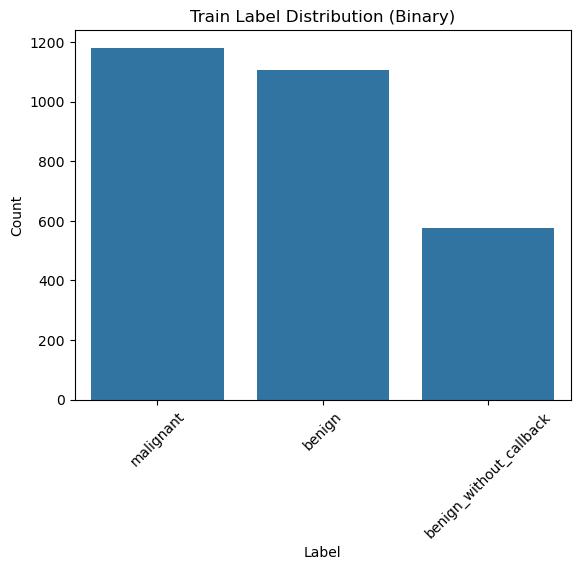

In [7]:
print("\nTrain set label distribution after normalization:")
print(train_df['label'].value_counts())

if LATERALITY_COL in train_df.columns:
    print("\nLaterality distribution:", train_df[LATERALITY_COL].value_counts(dropna=False))
if VIEW_COL in train_df.columns:
    print("\nImage view distribution:", train_df[VIEW_COL].value_counts(dropna=False))

sns.countplot(x='label', data=train_df)
plt.title('Train Label Distribution (Binary)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Train set summary (my read of the plots and counts)

I normalized the labels and tallied the train split. Here is how the data breaks down and what it means for my modeling choices.

Labels after normalization
- malignant: 1181 (≈ 41.3%)
- benign: 1105 (≈ 38.6%)
- benign_without_callback: 577 (≈ 20.2%)
- total: 2863

What this means for my tasks
- If I train a binary model (malignant vs non-malignant), the positive class is malignant and the negative class is benign + benign_without_callback = 1682 (≈ 58.7%). This is only a mild imbalance toward the negative class. I will start without heavy rebalancing, then consider class weights, focal loss, or threshold tuning if malignant recall lags.
- If I train a three-class model, benign_without_callback is roughly half the size of the other two classes. I will likely use class weights or balanced sampling so this class is not under-learned.

Laterality distribution
- LEFT: 1449 (≈ 50.6%)
- RIGHT: 1414 (≈ 49.4%)

This is essentially balanced. I do not expect systematic bias by side, but I will still report per-side metrics to confirm.

Image view distribution
- MLO: 1517 (≈ 53.0%)
- CC: 1346 (≈ 47.0%)

There is a mild skew toward MLO. I will stratify splits by view and also monitor per-view performance so the model does not overfit the more frequent projection.



Sample visualization
--------------------
I plot a few samples per class to quickly validate that paths resolve correctly and that assets are aligned. For each row I show the full image, the ROI mask, an overlay, and the cropped ROI (when available). I look for obvious red flags: masks offset from anatomy, empty or saturated masks, crops that miss the lesion, or mismatched classes. If I spot issues, I trace back to the folder and adjust the mask heuristic or filename rules before proceeding.



Displaying sample images for label: malignant
Sample 1 for label 'malignant':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.131861114610888161822097220104193388621\1-201.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.261038958613341762712247433262593053162\1-140.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.261038958613341762712247433262593053162\2-141.jpg
Sample 2 for label 'malignant':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.372857232512741811521561294420281719494\1-138.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692\1-105.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692\2-104.jpg
Sample 3 for label 'malignant':
 Image path: C:\Users\PC\Desktop\fi

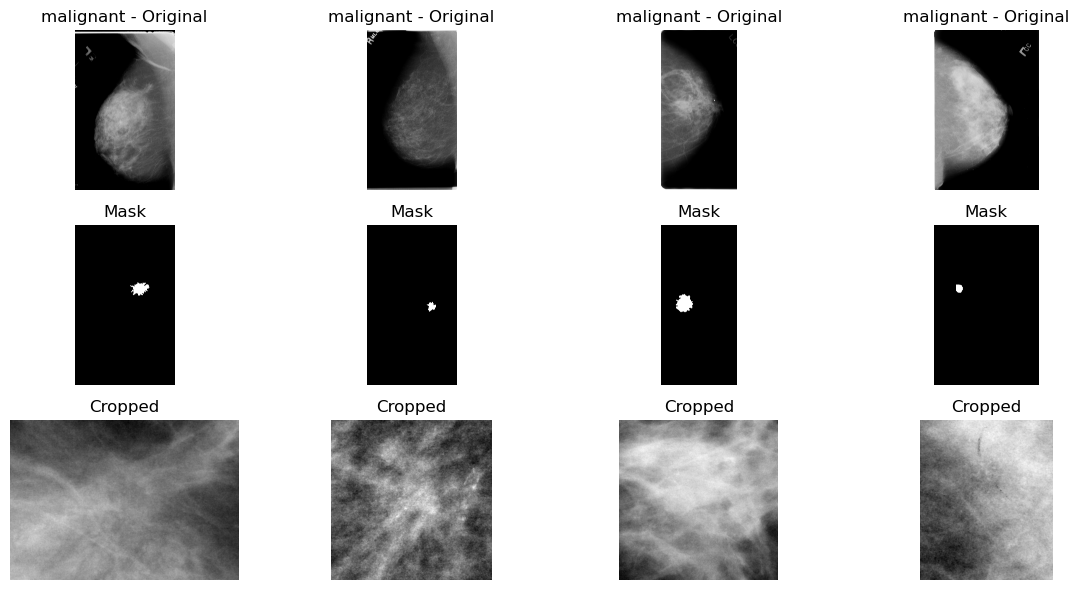


Displaying sample images for label: benign
Sample 1 for label 'benign':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.52915627412340525122930510274096143514\1-066.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.97276061412161245616899941151505383039\2-152.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.97276061412161245616899941151505383039\1-174.jpg
Sample 2 for label 'benign':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.334251952210807009101936723613306535511\1-082.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.189968356610649865535673586433840970668\1-285.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.243096104012726513620918828863555253127\1-021.jpg
Sample 3 for label 'benign':
 Image path: C:\Users\PC\Desktop\final project\CBI

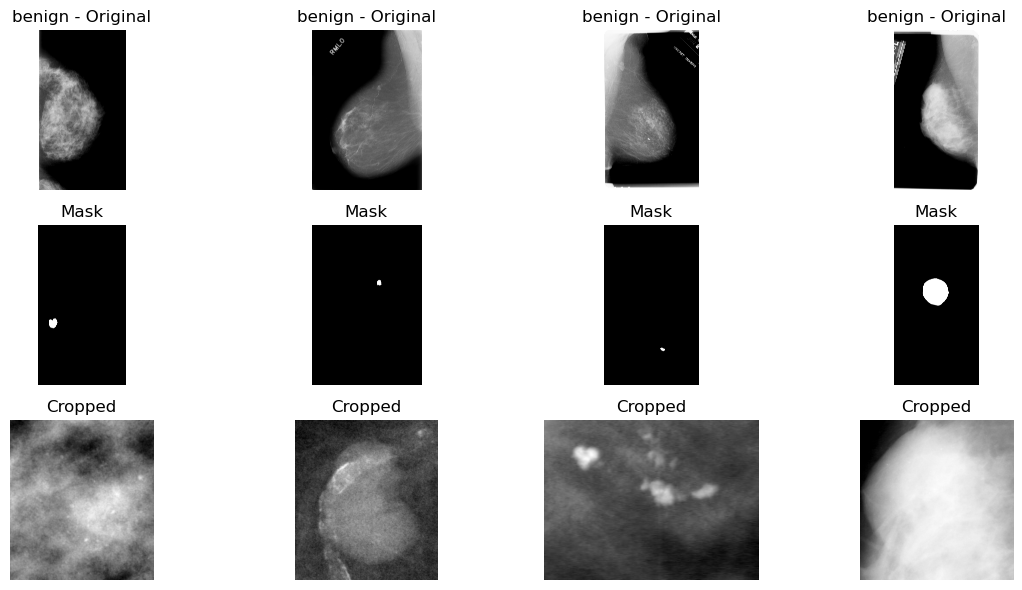


Displaying sample images for label: benign_without_callback
Sample 1 for label 'benign_without_callback':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112\1-230.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.249216516710813200139703395171404324515\2-238.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.249216516710813200139703395171404324515\1-260.jpg
Sample 2 for label 'benign_without_callback':
 Image path: C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.123693931011970170622114438543630155979\1-225.jpg
 Mask path:  C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.293196622311471040517423965530417529145\2-122.jpg
 Cropped:    C:\Users\PC\Desktop\final project\CBIS-DDSM\jpeg\1.3.6.1.4.1.9590.100.1.2.293196622311471040517423965530417529145\1-144.jpg
Sample 3 for label 'benig

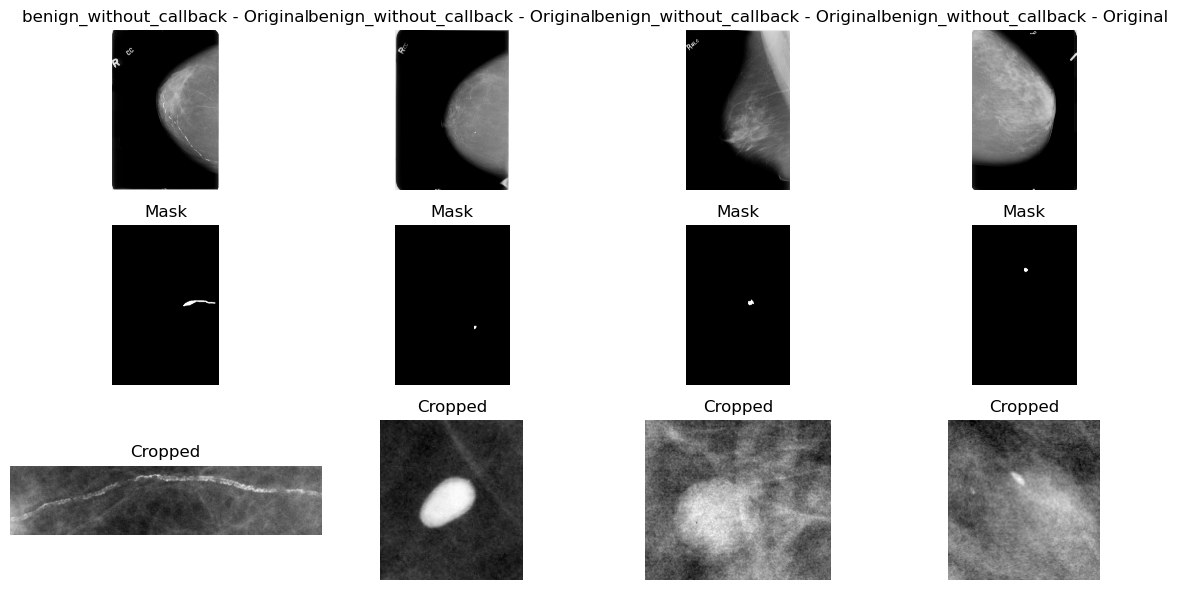

In [9]:
def show_samples_with_masks(df, label, n=4, random_state=42):
    """
    Display n samples of original images, corresponding ROI masks, and cropped images
    for a given class label from the dataset.
    """
    samples = df[df['label'] == label].sample(n, random_state=random_state)
    plt.figure(figsize=(12, 6))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            print(f"Sample {i+1} for label '{label}':")
            print(f" Image path: {row['image_path']}")
            print(f" Mask path:  {row['mask_path']}")
            print(f" Cropped:    {row['cropped_image_path']}")
            
            # Original
            img = Image.open(row['image_path'])
            plt.subplot(3, n, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{label} - Original")
            plt.axis('off')
            
            # Mask
            mask = Image.open(row['mask_path'])
            plt.subplot(3, n, n + i + 1)
            plt.imshow(mask, cmap='gray')
            plt.title("Mask")
            plt.axis('off')

            # Cropped
            cropped = Image.open(row['cropped_image_path'])
            plt.subplot(3, n, 2 * n + i + 1)
            plt.imshow(cropped, cmap='gray')
            plt.title("Cropped")
            plt.axis('off')

        except Exception as e:
            print(f"Error loading or displaying sample {i+1}: {e}")
    
    plt.tight_layout()
    plt.show()

for lbl in train_df['label'].unique():
    print(f"\nDisplaying sample images for label: {lbl}")
    show_samples_with_masks(train_df, lbl)

Preview and consolidated export (all splits)
--------------------------------------------
Here I create a single, canonical table that spans both train and test after preprocessing. I keep train and test tags in a split column so I can filter for evaluation, but having a unified artifact simplifies downstream code, joins, and bookkeeping. Before writing to disk I preview a few rows to verify that columns, dtypes, and path fields look correct.

What I include in the consolidated table
- resolved file paths for image, mask, and cropped ROI
- abnormality type so I can slice calcification and mass workflows
- laterality and view carried through for stratification and subgroup reporting
- normalized label in the compact target space I use for training
- split tags so I can reconstruct the official partitioning at any point

Why I prefer a single reference artifact
- source of truth for experiments: data loaders, EDA, and export scripts all read the same file
- fewer moving parts: avoiding parallel per-split files reduces drift and copy errors
- reproducibility: I can version this one file and know exactly what transformed inputs the models saw

Checks I perform before writing
- spot check that image_path and mask_path point to existing files
- confirm the expected columns are present and ordered consistently
- verify row counts align with earlier retention logs to catch accidental drops

Output contract
- the file is written once per run with deterministic content given the same inputs
- schema remains stable across runs so training code does not need conditional logic
- train and test can be recovered with a simple filter on the split column


In [13]:
print("\nSample paths after preprocessing:")
preview_cols = ['image file path', 'image_path', 'mask_path', 'cropped_image_path',
                LATERALITY_COL, VIEW_COL, 'label', 'split', 'category']
existing_preview = [c for c in preview_cols if c in train_df.columns]
display(train_df[existing_preview].head())

# Export CBIS preprocessed ALL (train+test, calc+mass)
all_df = pd.concat([train_df, test_df], ignore_index=True)

for col in (LATERALITY_COL, VIEW_COL):
    if col not in all_df.columns:
        all_df[col] = pd.NA

export_cols_all = [
    "image file path",
    "image_path",
    "mask_path",
    "cropped_image_path",
    "abnormality type",
    LATERALITY_COL,
    VIEW_COL,
    "label",
    "split",      # train / test
    "category",   # mass / calcification
]

out_all = os.path.join(data_dir, "cbis_preprocessed_all.csv")
all_df[export_cols_all].to_csv(out_all, index=False)
print(f"Saved ALL sets -> {out_all}  | rows={len(all_df)}")



Sample paths after preprocessing:


,image file path,image_path,mask_path,cropped_image_path,left or right breast,image view,label,split,category
0,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,RIGHT,CC,malignant,train,calcification
1,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,RIGHT,MLO,malignant,train,calcification
2,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,LEFT,CC,benign,train,calcification
3,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,LEFT,MLO,benign,train,calcification
4,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,LEFT,CC,benign_without_callback,train,calcification


Saved ALL sets -> C:\Users\PC\Desktop\final project\CBIS-DDSM\data\cbis_preprocessed_all.csv  | rows=3567


Train preview and export
------------------------
I produce a train-only artifact that mirrors the consolidated schema but contains just the training rows. This gives me a small, fast-loading reference for ad-hoc visual checks (overlays, crops, quick stratified summaries) without touching the test set.

How I use it
- rapid QA: sample a handful of rows and render image–mask–crop panels
- lightweight EDA: label balance and per-view/per-laterality tallies on the portion I will actually optimize on
- guardrails: keeps the test set out of my day-to-day debugging loop to avoid accidental peeking

Contract for this file
- same columns and dtypes as the consolidated table (paths, abnormality type, laterality, view, normalized label)
- written deterministically under BASE_DIR so loaders and helper notebooks can rely on a stable location
- not a final split: this is a convenience export for QA; I still create patient-level, stratified train/val indices later


In [14]:
# Ensure columns exist (in case a source CSV lacked them)
for col in (LATERALITY_COL, VIEW_COL):
    if col not in train_df.columns:
        print(f"[WARN] '{col}' missing in train_df — filling with <NA>")
        train_df[col] = pd.NA

# Preview with laterality/view
print("\nSample rows from the preprocessed train dataset:")
preview_cols = [
    'image file path', 'image_path', 'mask_path', 'cropped_image_path',
    'abnormality type', LATERALITY_COL, VIEW_COL, 'label'
]
existing_preview = [c for c in preview_cols if c in train_df.columns]
display(train_df[existing_preview].head())

# Export train_preprocessed.csv (under BASE_DIR when available)
export_cols = [
    'image file path', 'image_path', 'mask_path', 'cropped_image_path',
    'abnormality type', LATERALITY_COL, VIEW_COL, 'label'
]
existing_export = [c for c in export_cols if c in train_df.columns]

out_path = (os.path.join(data_dir, 'train_preprocessed.csv')
            if 'BASE_DIR' in globals() else 'train_preprocessed.csv')

train_df[existing_export].to_csv(out_path, index=False)
print(f"Saved train_preprocessed with laterality/view -> {out_path}")



Sample rows from the preprocessed train dataset:


,image file path,image_path,mask_path,cropped_image_path,abnormality type,left or right breast,image view,label
0,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,RIGHT,CC,malignant
1,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,RIGHT,MLO,malignant
2,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,CC,benign
3,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,MLO,benign
4,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,CC,benign_without_callback


Saved train_preprocessed with laterality/view -> C:\Users\PC\Desktop\final project\CBIS-DDSM\data\train_preprocessed.csv


Alignment overlay utilities
---------------------------
Before I commit to training, I verify that spatial relationships are correct. The overlay helpers render, for each sampled case, the full image, the binary mask, an overlay of mask on image, and the cropped ROI. This lets me quickly confirm that:

- the mask foreground sits on the anatomy it is supposed to delineate (no offsets or flips)
- foreground coverage is plausible (not empty, not the whole frame)
- the cropped ROI actually contains the lesion and not background
- the class label matches what the mask suggests (sanity check against label normalization)

Typical failure modes I watch for
- path mix-ups where image and mask folders diverge and produce misaligned pairs
- masks saved as low-contrast photographs (the mask heuristic would misclassify)
- crops derived from the wrong frame or with incorrect coordinates

How I use the panels
- I sample a small batch per class and skim for obvious misalignment
- when I find issues, I trace back to the specific folder and adjust the mask heuristic or add filename-pattern rules
- once overlays look consistent, I proceed to data loaders and model training knowing the supervision is spatially coherent


In [15]:
def overlay_mask_on_image(image_path, mask_path, alpha=0.4):
    """
    Overlay the ROI mask on the original grayscale mammogram.
    Args:
        image_path (str): Path to the full image.
        mask_path (str): Path to the ROI mask image.
        alpha (float): Transparency level of the mask overlay.
    """
    try:
        image = Image.open(image_path).convert('L')  # Convert image to grayscale
        mask = Image.open(mask_path).convert('L')    # Convert mask to grayscale

        image_np = np.array(image)
        mask_np = np.array(mask)

        plt.imshow(image_np, cmap='gray')
        plt.imshow(mask_np, cmap='jet', alpha=alpha)
        plt.title("Overlay: Image + Mask")
        plt.axis('off')
    except Exception as e:
        print(f"Overlay error: {e}")

def show_alignment_samples(df, n=4, label_filter=None):
    """
    Display a visual comparison for a given number of samples:
    full image, ROI mask, overlay, and cropped region.
    """
    if label_filter:
        df = df[df['label'] == label_filter]

    samples = df.sample(n)
    plt.figure(figsize=(16, 4 * n))

    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            # Load all image components
            image = Image.open(row['image_path']).convert('L')
            mask = Image.open(row['mask_path']).convert('L')
            cropped = Image.open(row['cropped_image_path']).convert('L')

            image_np = np.array(image)
            mask_np = np.array(mask)
            cropped_np = np.array(cropped)

            # Full image
            plt.subplot(n, 4, 4 * i + 1)
            plt.imshow(image_np, cmap='gray')
            plt.title(f"Full Image ({row['label']})")
            plt.axis('off')

            # ROI mask
            plt.subplot(n, 4, 4 * i + 2)
            plt.imshow(mask_np, cmap='gray')
            plt.title("Mask")
            plt.axis('off')

            # Overlay
            plt.subplot(n, 4, 4 * i + 3)
            overlay_mask_on_image(row['image_path'], row['mask_path'])

            # Cropped ROI
            plt.subplot(n, 4, 4 * i + 4)
            plt.imshow(cropped_np, cmap='gray')
            plt.title("Cropped ROI")
            plt.axis('off')

        except Exception as e:
            print(f"Error loading sample {i+1}: {e}")

    plt.tight_layout()
    plt.show()


Run alignment checks on train_preprocessed
------------------------------------------
Here I sanity-check spatial alignment using only the curated training table. I load `train_preprocessed.csv`, sample a small batch deterministically (fixed seed), and render for each case the full image, the mask, an overlay, and the cropped ROI. I expect the mask foreground to sit on the lesion, the overlay to highlight plausible anatomy, and the crop to center the region of interest.

What I am verifying
- the path-resolution logic produces image–mask pairs that align in pixel space
- the cropped ROI is consistent with the mask and not an unrelated patch
- the normalized label agrees with what the mask suggests (high-level sanity)

How I run it
- draw n random rows from the training table with a fixed seed so results are reproducible
- display the four-panel view per sample and skim for obvious failures (offset masks, empty masks, crops missing the lesion)

If I find issues
- trace back to the specific folder to see whether the heuristic mis-identified a mask or crop
- tighten the selection rules (for example add filename-pattern matching) and re-run this check
- only proceed to model training once overlays look consistently correct


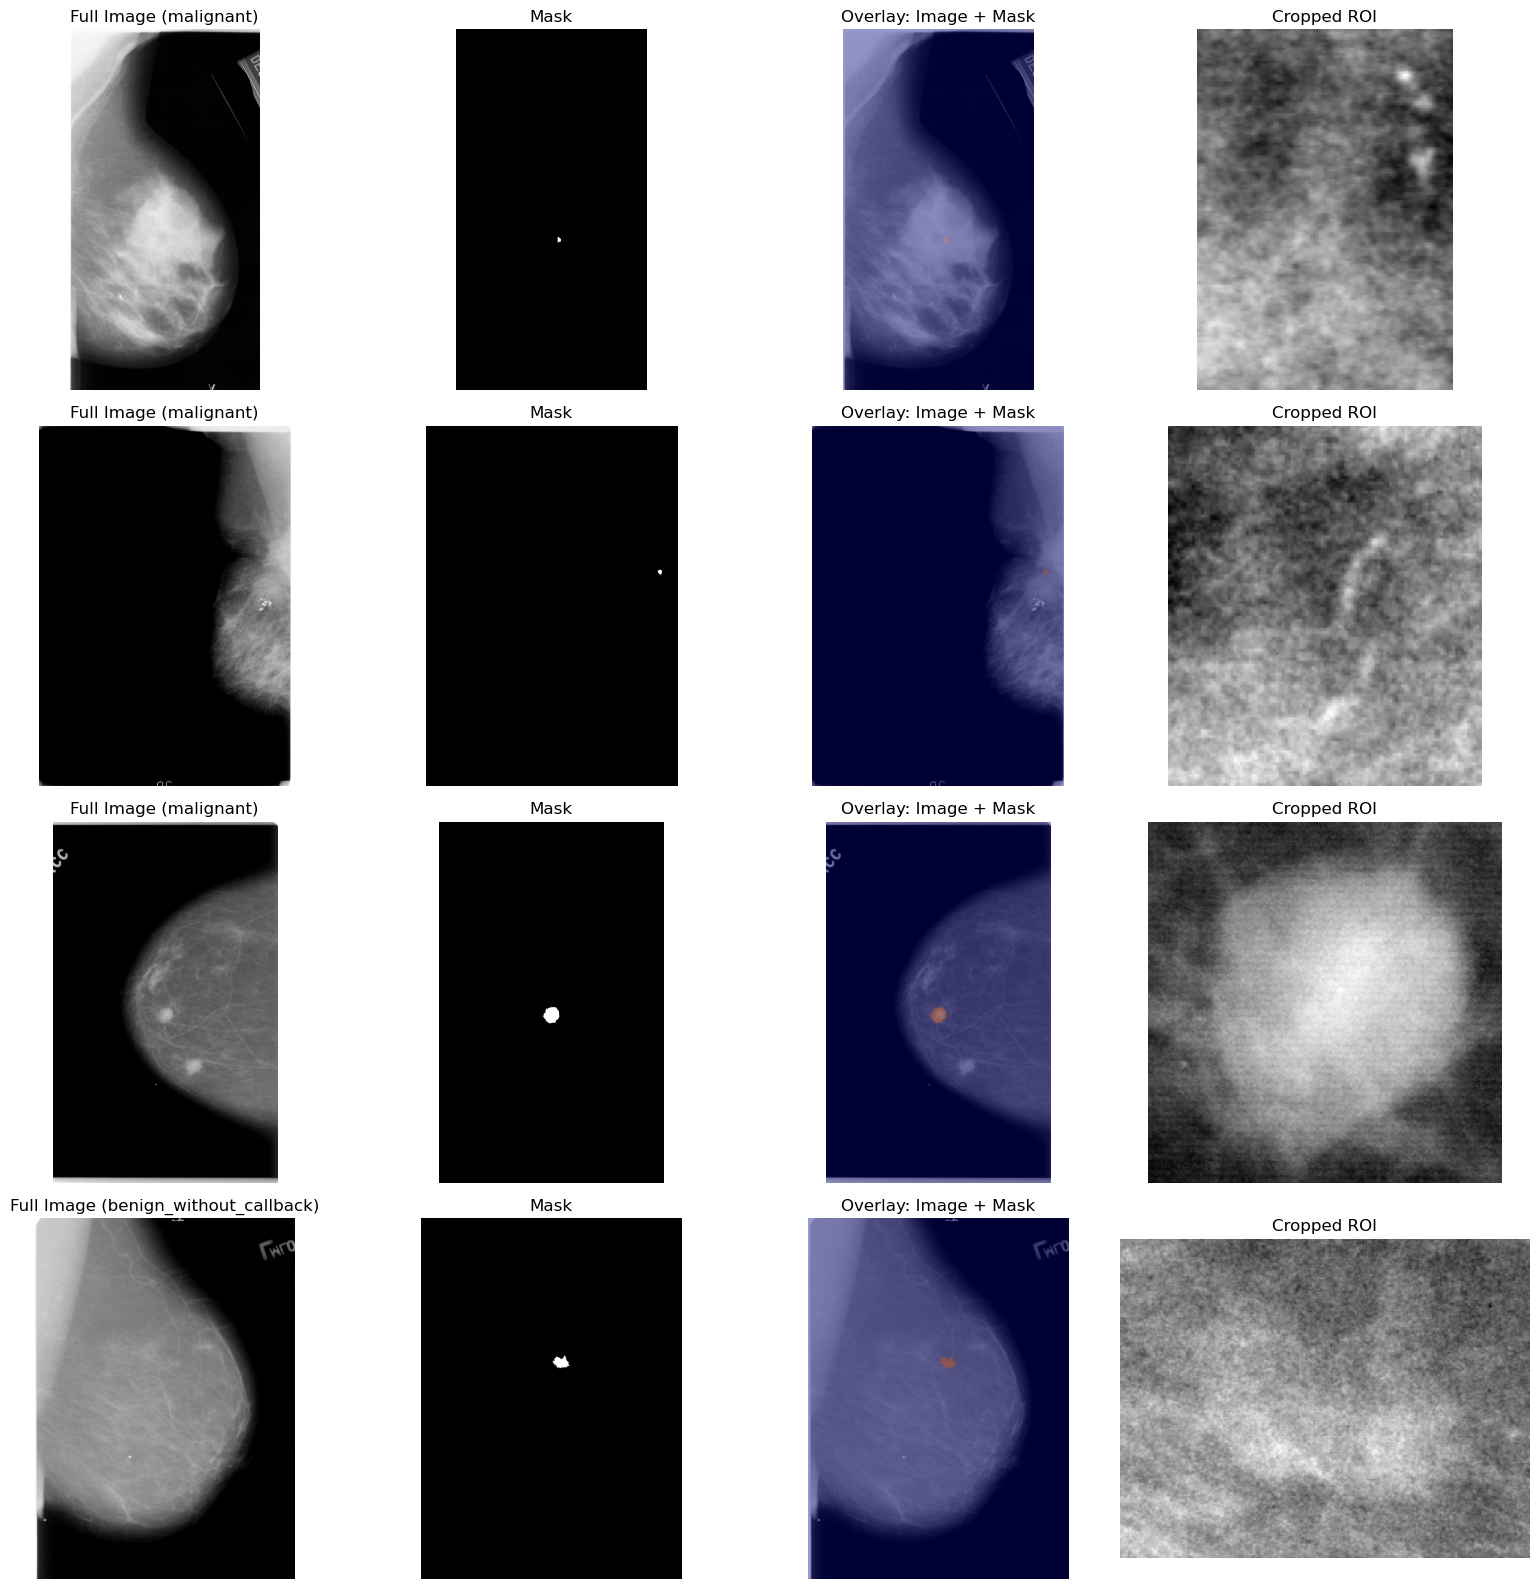

In [17]:
train_pre_csv = (os.path.join(data_dir, 'train_preprocessed.csv')
                 if 'BASE_DIR' in globals() else 'train_preprocessed.csv')
df = pd.read_csv(train_pre_csv)

show_alignment_samples(df, n=4)

Build ML-ready tables
---------------------
Here I convert the consolidated, path-resolved table into a model-ready representation with explicit targets and fixed categorical encodings. My objective is to produce a compact, schema-stable CSV that my data loaders can consume without additional munging.

Targets I materialize
- binary label: I map pathology to y ∈ {0,1} with malignant → 1 and benign/benign_without_callback → 0. This is the default target I optimize in most experiments.
- I keep the normalized string label alongside the numeric target so I can pivot to a three-class head later without reprocessing.

Categorical encoding
- laterality and view are one-hot encoded into laterality_LEFT, laterality_RIGHT, view_CC, view_MLO.
- I predeclare the category vocabularies and reindex the dummy columns to ensure a fixed set even when a category is absent in a split. Missing categories become zero-filled columns, which keeps the feature schema identical across train and test.

Type and memory choices
- I store one-hot columns and the numeric label as int8 to reduce memory footprint and speed up I/O.
- I leave path fields and the abnormality type as strings. Numerical intensity features are not introduced here; model-side transforms read images from disk using the paths.

Schema guarantees I enforce
- stable column names with explicit prefixes for categorical dummies
- no NaNs in targets or one-hot columns after encoding
- presence of the split tag so I can recover train/test with a simple filter
- preserved path columns (image_path, mask_path, cropped_image_path) for loaders that need both classification and localization views

Quick validation I run before export
- check value counts of the numeric target and confirm they match the earlier label distribution (after collapsing benign_without_callback)
- assert that all expected one-hot columns exist and are dtype int8
- verify that at least image_path and mask_path resolve to existing files on a small random sample

Why I prefer this design
- it separates supervision (targets and metadata) from the image pixels, which are loaded and augmented on the fly
- it keeps the feature space small and interpretable while remaining extensible (I can add more metadata columns later without breaking loaders)
- it remains agnostic to the model family; any image model can pair these targets with on-disk pixels

Outcome of this step
- a compact, reproducible table with numeric targets and fixed one-hot metadata that serves as the direct input to my training code


In [19]:
data_set = os.path.join(data_dir, 'cbis_preprocessed_all.csv') if 'BASE_DIR' in globals() else 'cbis_preprocessed_all.csv'
df_all = pd.read_csv(data_set)

print("Head of consolidated dataset:")
display(df_all.head())

print("\nUnique abnormality types:", df_all['abnormality type'].unique())

# Drop optional category if present
df_all = df_all.drop(columns=['category'], errors='ignore')

# Normalize labels to numeric targets
df_all['label'] = df_all['label'].astype(str).str.lower().map({
    "malignant": 1,
    "benign": 0,
    "benign_without_callback": 0
}).astype("int8")

# One-hot laterality/view
df_all = pd.get_dummies(
    df_all,
    columns=['left or right breast', 'image view'],
    prefix=['laterality','view'],
    prefix_sep='_',
    dtype='int8'
)

print("\nHead after label mapping and one-hot encoding:")
display(df_all.head())


Head of consolidated dataset:


,image file path,image_path,mask_path,cropped_image_path,abnormality type,left or right breast,image view,label,split,category
0,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,RIGHT,CC,malignant,train,calcification
1,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,RIGHT,MLO,malignant,train,calcification
2,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,CC,benign,train,calcification
3,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,MLO,benign,train,calcification
4,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,LEFT,CC,benign_without_callback,train,calcification



Unique abnormality types: ['calcification' 'mass']

Head after label mapping and one-hot encoding:


,image file path,image_path,mask_path,cropped_image_path,abnormality type,label,split,laterality_LEFT,laterality_RIGHT,view_CC,view_MLO
0,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,1,train,0,1,1,0
1,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,1,train,0,1,0,1
2,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,0,train,1,0,1,0
3,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,0,train,1,0,0,1
4,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,C:\Users\PC\Desktop\final project\CBIS-DDSM\jp...,calcification,0,train,1,0,1,0


Export final per-category CSVs
------------------------------
I produce two task-specific artifacts: one for calcification and one for mass. Separating the outputs at this stage makes downstream experimentation simpler because each training script can bind directly to the relevant pathology without additional filtering logic.

What I include in each export
- image_path, mask_path, cropped_image_path so loaders can choose between full-image, weakly supervised (mask-guided), or ROI-centric training
- numeric target y ∈ {0,1} with malignant → 1 and benign/benign_without_callback → 0
- one-hot metadata for laterality and view encoded as compact int8 columns
- abnormality type retained for traceability even though each file is already category-specific
- split tag so I can reconstruct train/test partitions from a single artifact

Why I split by abnormality now
- simplifies training code: each recipe reads a single CSV with a consistent pathology definition and does not need runtime filters
- reduces accidental class leakage: calcification and mass can have different visual statistics and label priors; dedicated files keep my sampling, augmentation, and model choices tightly scoped
- enables independent iteration: I can adjust preprocessing or augmentations for one pathology without perturbing the other

Sanity checks I run before writing
- confirm that label mapping and one-hot columns match the consolidated schema
- verify that row counts equal the subset of the consolidated table for the given abnormality type
- spot check that path columns still resolve to files on disk

Contract for these files
- stable schema across runs so training jobs remain reproducible
- compact dtypes for fast I/O at scale
- self-contained: each file is sufficient for training its pathology-specific model with no additional joins or filters


In [20]:
calc_out = os.path.join(data_dir, 'calc_preprocessed_clean.csv') if 'BASE_DIR' in globals() else 'calc_preprocessed_clean.csv'
mass_out = os.path.join(data_dir, 'mass_preprocessed_clean.csv') if 'BASE_DIR' in globals() else 'mass_preprocessed_clean.csv'

is_calc = df_all['abnormality type'].astype(str).str.strip().str.lower().eq('calcification')
is_mass = df_all['abnormality type'].astype(str).str.strip().str.lower().eq('mass')

df_all[is_calc].to_csv(calc_out, index=False)
df_all[is_mass].to_csv(mass_out, index=False)

print(f"Saved calcification table -> {calc_out} | rows={df_all[is_calc].shape[0]}")
print(f"Saved mass table          -> {mass_out} | rows={df_all[is_mass].shape[0]}")


Saved calcification table -> C:\Users\PC\Desktop\final project\CBIS-DDSM\data\calc_preprocessed_clean.csv | rows=1871
Saved mass table          -> C:\Users\PC\Desktop\final project\CBIS-DDSM\data\mass_preprocessed_clean.csv | rows=1696
